In [1]:
import os.path
import sys

from keras import callbacks, models
from datahandler.constants import all_features, data_version, acc_features, tensorboard_dir, location_labels
from datahandler.data_preprocessing import get_train_test_data, load_data_v3
from models.log_writer import LogWriter
from model.lstm import make_lstm_model_v1
from model.transformer import make_transformer_model_v1
from model.cnn import make_cnn_model_v1, make_cnn_model_v2
import matplotlib.pyplot as plt
from utils import print_line_divider
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from datahandler.data_preprocessing_from_jupyter import load_train_test_data_raw_normalized, load_train_test_data_added_features_normalized, load_train_test_data_added_features_pca
from audio.audio import play_training_is_complete

In [2]:
# LOGGING CONFIGURATION
enabled_log = False
enabled_tensor_board = False
log_writer = LogWriter(enabled_log)

In [3]:
# TRAINING CONFIGURATION
print("STARTING THE TRAINING PROCESS")
SAVED_BEST_MODEL = "model/best_model.h5"
window_time_in_seconds = 2
window_size = 40
epochs = 300
batch_size = 32
validation_split = 1 / 9
optimizer = 'adam'
loss_function = "sparse_categorical_crossentropy"
supported_features = all_features

STARTING THE TRAINING PROCESS


In [4]:
log_writer.write("Configuration", line_divider=True)
log_writer.write(
    f"""Window size: {window_size}
Window time in second: ${window_time_in_seconds}
Maximum number of epochs: ${epochs}
Batch size: ${batch_size}
Validation split: ${validation_split}
Optimizer: ${optimizer}
Loss function: ${loss_function}
Features used for training: ${str(supported_features)}"""
)

In [ ]:
# DATA Loader
print_line_divider()
print("Preparing data...")
# x_train, y_train, x_test, y_test = get_train_test_data(supported_features, window_time_in_seconds, window_size)
# x_train, y_train, x_test, y_test = load_data_v3(
#     features = supported_features,
#     window_time_in_seconds = window_time_in_seconds,
#     window_size = window_size
# )
x_train, y_train, x_test, y_test = load_train_test_data_added_features_normalized()
print("Train data shape: " + str(x_train.shape) + " | Train label shape: " + str(y_train.shape))
print("Test data shape: " + str(x_test.shape) + " | Test label shape: " + str(y_test.shape))
print_line_divider()


****************************************************
Preparing data...
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v3/train/px4_datacollection.csv (1/24)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v3/train/ps1_datacollection.csv (2/24)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v3/train/tc4_datacollection.csv (3/24)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v3/train/ss3_datacollection.csv (4/24)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v3/train/ps2_datacollection.csv (5/24)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v3/train/op4_datacollection.csv (6/24)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_transformer/data/v3/train/op2_datacollection.csv (7/24)
Loading from file: /Users/duc.letran/Desktop/FINAL PROJECT/context_t

KeyboardInterrupt: 

Exception ignored in: 'pandas._libs.tslibs.conversion._localize_tso'
Traceback (most recent call last):
  File "pandas/_libs/tslibs/timezones.pyx", line 268, in pandas._libs.tslibs.timezones.get_dst_info
KeyboardInterrupt: 


In [ ]:
log_writer.write("Data", line_divider=True)
log_writer.write("Data loaded from version " + data_version)
log_writer.write(
    f"""Data training shape: ${x_train.shape}
Data testing shape: ${x_test.shape}"""
)

In [ ]:
def check_distribution(labels_list, set_name):
    label_count_dict = {}
    for label_ind in labels_list:
        if label_ind in label_count_dict.keys():
            label_count_dict[label_ind] += 1
        else:
            label_count_dict[label_ind] = 1

    print_line_divider()
    print("Distribution for set " + set_name + "\n")
    for key in label_count_dict:
        key = int(key)
        print(location_labels[key] + " count is " + str(label_count_dict[key]))


check_distribution(y_train, "Training set")
check_distribution(y_test, "Testing set")

In [ ]:
if len(x_train.shape) == 2:
    input_shape = (x_train.shape[1], 1)
else:
    input_shape = x_train.shape[1:]
print("Input shape: " + str(input_shape))

In [50]:
# SETTING UP THE MODEL
# input_shape = x_train.shape[1:] # (window_size, len(supported_features))
# model_name, model = make_cnn_model_v1(input_shape=input_shape)
# model_name, model = make_lstm_model_v1(input_shape=input_shape)
model_name, model = make_transformer_model_v1(
    input_shape=input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=2,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)
print("Model Summary:")
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)
print(print_line_divider())

Model Summary:
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40, 9)]      0           []                               
                                                                                                  
 layer_normalization_4 (LayerNo  (None, 40, 9)       18          ['input_3[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_2 (MultiH  (None, 40, 9)       39945       ['layer_normalization_4[0][0]',  
 eadAttention)                                                    'layer_normalization_4[0][0]']  
                                                                             

In [51]:
# LOGGING THE MODEL
log_writer.write("Model", line_divider=True)
log_writer.write("Model name: " + model_name)
log_writer.write(short_model_summary)

In [52]:
# MODELS CALLBACK AND SETUP
callback_list = [
    callbacks.ModelCheckpoint(SAVED_BEST_MODEL, save_best_only=True, monitor="val_loss"),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=50, min_lr=0.0001),
    callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1)
]
if enabled_tensor_board:
    callback_list.append(callbacks.TensorBoard(log_dir=tensorboard_dir, histogram_freq=1))
if log_writer.enabled:
    callback_list.append(
        callbacks.ModelCheckpoint(log_writer.base_folder + "/model.h5", save_best_only=True, monitor="val_loss")
    )
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=["sparse_categorical_accuracy"],
)

In [53]:
# TRAINING
print_line_divider()
print("Starting to train...")
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callback_list,
    validation_split=validation_split,
    verbose=1,
    shuffle=True
)
print("Highest validation accuracy: ", max(history.history['val_sparse_categorical_accuracy']))
log_writer.write("Result", line_divider=True)
log_writer.write("Highest validation accuracy: " + str(max(history.history['val_sparse_categorical_accuracy'])))
play_training_is_complete()

****************************************************
Starting to train...
Epoch 1/300
162/162 [==============================] - 21s 120ms/step - loss: 1.1155 - sparse_categorical_accuracy: 0.4371 - val_loss: 1.3792 - val_sparse_categorical_accuracy: 0.3704 - lr: 0.0010
Epoch 2/300
162/162 [==============================] - 18s 110ms/step - loss: 0.8433 - sparse_categorical_accuracy: 0.6100 - val_loss: 1.6080 - val_sparse_categorical_accuracy: 0.4753 - lr: 0.0010
Epoch 3/300
162/162 [==============================] - 18s 113ms/step - loss: 0.6236 - sparse_categorical_accuracy: 0.7350 - val_loss: 1.8541 - val_sparse_categorical_accuracy: 0.5231 - lr: 0.0010
Epoch 4/300
162/162 [==============================] - 18s 110ms/step - loss: 0.4783 - sparse_categorical_accuracy: 0.8159 - val_loss: 1.1186 - val_sparse_categorical_accuracy: 0.5926 - lr: 0.0010
Epoch 5/300
162/162 [==============================] - 18s 111ms/step - loss: 0.3561 - sparse_categorical_accuracy: 0.8705 - val_loss: 1.9

Input #0, wav, from '/var/folders/ph/8yv0q18n4mb1439tnf3rzcf40000gp/T/tmp1vjesrre.wav':
  Duration: 00:00:02.27, bitrate: 705 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 1 channels, s16, 705 kb/s


In [54]:
if log_writer.enabled:
    model.save(log_writer.base_folder + "/model_last.h5")

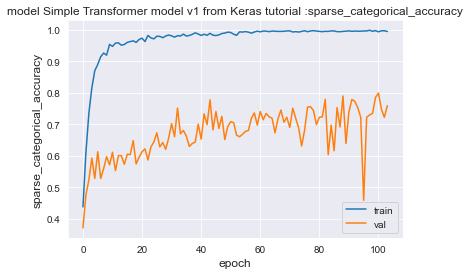

In [55]:
# PLOTTING
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + model_name + " :" + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
if log_writer.enabled:
    plt.savefig(os.path.join(log_writer.base_folder, "Validation progress.png"))
plt.show()
plt.close()

43/43 [==============================] - 3s 54ms/step - loss: 0.7933 - sparse_categorical_accuracy: 0.6413
****************************************************
Test accuracy 0.6412884593009949
Test loss 0.793317973613739


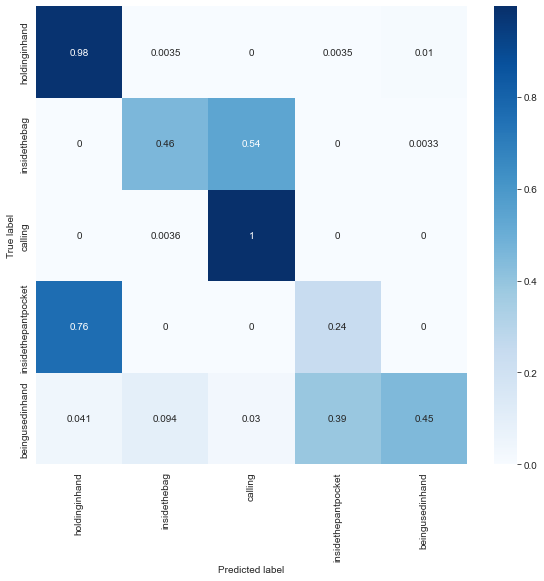

In [56]:
# EVALUATION
model = models.load_model(SAVED_BEST_MODEL)

test_loss, test_acc = model.evaluate(x_test, y_test)
print_line_divider()
print("Test accuracy", test_acc)
print("Test loss", test_loss)

# Accuracy based on different labels
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=4)
con_mat_df = pd.DataFrame(con_mat_norm, index=location_labels, columns=location_labels)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
if log_writer.enabled:
    plt.savefig(os.path.join(log_writer.base_folder, "Accuracy.png"))
plt.show()
plt.close()

log_writer.write("Test evaluation", line_divider=True)
log_writer.write("Test accuracy: " + str(test_acc))
log_writer.write("Test loss: " + str(test_loss))
log_writer.close()